In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ruturajmore","key":"82a6a811e9e4b282c26a46d525c24fa5"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [3]:
#loading dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

 77% 51.0M/66.0M [00:00<00:00, 70.1MB/s]
100% 66.0M/66.0M [00:00<00:00, 134MB/s] 


In [4]:
pip install pytablewriter

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 235kB 10.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninstalled python-dateutil-2.5.3


In [0]:
#importing libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
import zipfile
import math
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pytablewriter
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pytablewriter

In [0]:
#reading zip file
with zipfile.ZipFile("creditcardfraud.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [7]:
cre=pd.read_csv('data/creditcard.csv')
cre.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
cre.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


0    284315
1       492
Name: Class, dtype: int64

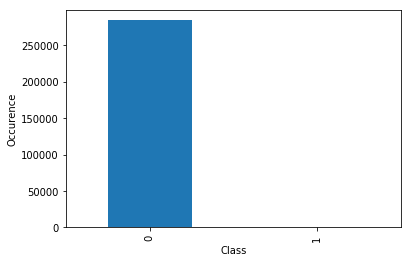

In [9]:
#analysing class:
pd.value_counts(cre['Class']).plot.bar()
plt.ylabel('Occurence')
plt.xlabel('Class')
cre['Class'].value_counts()

In [10]:
#checking null value:
print(cre.isnull().head())

    Time     V1     V2     V3     V4  ...    V26    V27    V28  Amount  Class
0  False  False  False  False  False  ...  False  False  False   False  False
1  False  False  False  False  False  ...  False  False  False   False  False
2  False  False  False  False  False  ...  False  False  False   False  False
3  False  False  False  False  False  ...  False  False  False   False  False
4  False  False  False  False  False  ...  False  False  False   False  False

[5 rows x 31 columns]


In [11]:
#checking duplicates:
cre.duplicated(subset=None, keep='first').head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [12]:
#'Time' & 'Amount' coloumns are remainning for scaling:
std_scaler = StandardScaler()
cre['NewAmount'] = std_scaler.fit_transform(cre['Amount'].values.reshape(-1, 1))
cre = cre.drop(['Time', 'Amount'], axis=1)
cre.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,NewAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


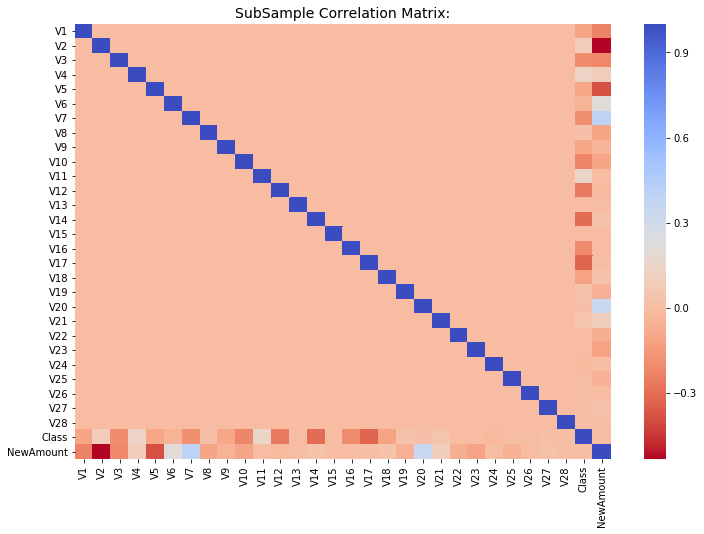

In [13]:
#plotting correlation matrix
f,ax2 = plt.subplots(1, figsize=(12,8))
sub_sample_corr = cre.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix:', fontsize=14)
plt.show()

In [14]:
models_performence = {
    'Sampling':[],
    'Model':[],
    'SearchCV':[],
    'Scoring Metrics': [],
    'Train_model_score': [],
    'Test_model_score': [],
    'best panalty': [],
    'Best lambda':[],
}

columns = ["Sampling","Model","SearchCV", "Scoring Metrics","Train_model_score","Test_model_score", "best panalty","Best lambda"]
print(len(columns))
pd.DataFrame(models_performence, columns=columns)

8


,Sampling,Model,SearchCV,Scoring Metrics,Train_model_score,Test_model_score,best panalty,Best lambda


In [0]:
# result_display  is function to convert dataframe into table format in Markdown
def result_display(df):
    writer = pytablewriter.MarkdownTableWriter()
    #writer.table_name = name
    writer.header_list = list(df.columns.values)
    writer.value_matrix = df.values.tolist()
    writer.write_table()

#Using Over-Sampling (SMOTE):

In [16]:
#train-test splitting
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = cre.drop('Class', axis=1)
y = cre['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", Y_train.shape)
print("Number transactions X_test  dataset: ", X_test.shape)
print("Number transactions y_test  dataset: ", Y_test.shape)

Number transactions X_train dataset:  (199364, 29)
Number transactions y_train dataset:  (199364,)
Number transactions X_test  dataset:  (85443, 29)
Number transactions y_test  dataset:  (85443,)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [17]:
#SMOTE on train
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(Y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(Y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(Y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(Y_train_res==0)))

Before OverSampling, counts of label '1': 345
Before OverSampling, counts of label '0': 199019 

After OverSampling, the shape of train_X: (398038, 29)
After OverSampling, the shape of train_y: (398038,) 

After OverSampling, counts of label '1': 199019
After OverSampling, counts of label '0': 199019


In [18]:
#Logistic Regression
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
d = ['accuracy','precision','recall','f1'] 
for i in range(len(d)): 
  p = d[i]
  clf = GridSearchCV(lr, parameters, scoring = p, cv=5, verbose=5, n_jobs=3)
  clf.fit(X_train_res, Y_train_res.ravel())
  models_performence['Model'].append('Logistic Regression')
  models_performence['Sampling'].append('SMOTE')
  models_performence['SearchCV'].append('GridSearchCV')
  models_performence['Scoring Metrics'].append(p)
  Test_model_score = clf.score(X_train_res,Y_train_res)
  Train_model_score = clf.score(X_test,Y_test)
  models_performence['Train_model_score'].append(Train_model_score.mean())
  models_performence['Test_model_score'].append(Test_model_score.mean())
  models_performence['best panalty'].append('l1')
  optimal_l1=clf.best_estimator_.get_params()['C']
  models_performence['Best lambda'].append(optimal_l1)
              

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  4.3min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  4.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  4.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  4.1min finished


In [19]:
clf.best_params_

{'C': 4.0}

In [20]:
optimal_l1=clf.best_estimator_.get_params()['C']
print(optimal_l1)

4.0


In [21]:
lr1 = LogisticRegression(C=optimal_l1,penalty='l1', verbose=5)
lr1.fit(X_train_res, Y_train_res.ravel())

[LibLinear]

LogisticRegression(C=4.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=5,
                   warm_start=False)

In [22]:
columns = ["Sampling","Model","SearchCV", "Scoring Metrics","Train_model_score","Test_model_score", "best panalty","Best lambda"]
print(len(columns))
df=pd.DataFrame(models_performence, columns=columns)

8


In [23]:
result_display(df)

|Sampling|       Model       |  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|best panalty|Best lambda|
|--------|-------------------|------------|---------------|----------------:|---------------:|------------|----------:|
|SMOTE   |Logistic Regression|GridSearchCV|accuracy       |          0.97525|          0.9452|l1          |          4|
|SMOTE   |Logistic Regression|GridSearchCV|precision      |          0.06032|          0.9731|l1          |          1|
|SMOTE   |Logistic Regression|GridSearchCV|recall         |          0.91837|          0.9157|l1          |          4|
|SMOTE   |Logistic Regression|GridSearchCV|f1             |          0.11321|          0.9435|l1          |          4|


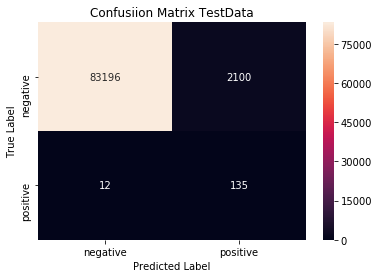

In [24]:
#confusion matrix
from sklearn.metrics import confusion_matrix
y_pre = lr1.predict(X_test)
cm = confusion_matrix(Y_test ,y_pre)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix TestData")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [25]:
tmp = lr1.fit(X_train_res, Y_train_res.ravel())


[LibLinear]

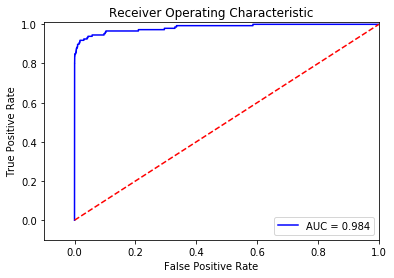

In [26]:
#ROC
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(Y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Using undersampling:

In [0]:
#Under-Sampling
cre = cre.sample(frac=1)


# amount of fraud classes 492 rows.
fraud_df = cre.loc[cre['Class'] == 1]
non_fraud_df = cre.loc[cre['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
cre_new = normal_distributed_df.sample(frac=1, random_state=42)

cre_new.head()
cre_new.shape
X = cre_new.drop('Class', axis=1)
y = cre_new['Class']



In [28]:
#splitting data into Test and Train
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
import numpy as np

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Label Distributions: 

[0.5 0.5]
[0.5 0.5]


In [29]:
#Logistic Regression
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
d = ['accuracy','precision','recall','f1'] 
for i in range(len(d)): 
  p = d[i]
  clf = GridSearchCV(lr, parameters, scoring = p, cv=5, verbose=5, n_jobs=3)
  clf_new = clf.fit(original_Xtrain, original_ytrain.ravel())
  models_performence['Model'].append('Logistic Regression')
  models_performence['Sampling'].append('UnderSampling')
  models_performence['SearchCV'].append('GridSearchCV')
  models_performence['Scoring Metrics'].append(p)
  Test_model_score = clf.score(original_Xtrain, original_ytrain)
  Train_model_score = clf.score(original_Xtest, original_ytest)
  models_performence['Train_model_score'].append(Train_model_score.mean())
  models_performence['Test_model_score'].append(Test_model_score.mean())
  models_performence['best panalty'].append('l1')
  optimal_l1=clf.best_estimator_.get_params()['C']
  models_performence['Best lambda'].append(optimal_l1)
              

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=3)]: Done  34 out of  50 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    3.0s finished


In [30]:
optimal_l1=clf_new.best_estimator_.get_params()['C']
print(optimal_l1)

5.0


In [31]:
lr1 = LogisticRegression(C=optimal_l1,penalty='l1', verbose=5)
lr1.fit(original_Xtrain, original_ytrain.ravel())

[LibLinear]

LogisticRegression(C=5.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=5,
                   warm_start=False)

In [32]:
columns = ["Sampling","Model","SearchCV", "Scoring Metrics","Train_model_score","Test_model_score", "best panalty","Best lambda"]
print(len(columns))
df=pd.DataFrame(models_performence, columns=columns)

8


In [33]:
result_display(df)

|  Sampling   |       Model       |  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|best panalty|Best lambda|
|-------------|-------------------|------------|---------------|----------------:|---------------:|------------|----------:|
|SMOTE        |Logistic Regression|GridSearchCV|accuracy       |          0.97525|          0.9452|l1          |          4|
|SMOTE        |Logistic Regression|GridSearchCV|precision      |          0.06032|          0.9731|l1          |          1|
|SMOTE        |Logistic Regression|GridSearchCV|recall         |          0.91837|          0.9157|l1          |          4|
|SMOTE        |Logistic Regression|GridSearchCV|f1             |          0.11321|          0.9435|l1          |          4|
|UnderSampling|Logistic Regression|GridSearchCV|accuracy       |          0.94898|          0.9518|l1          |          5|
|UnderSampling|Logistic Regression|GridSearchCV|precision      |          0.94898|          0.9759|l1          |          5|


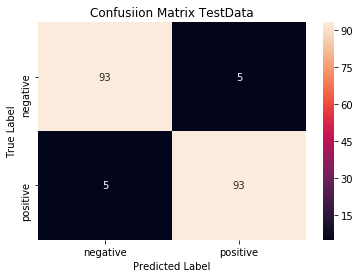

In [34]:
#confusion matrix
from sklearn.metrics import confusion_matrix
y_pre = lr1.predict(original_Xtest)
cm = confusion_matrix(original_ytest ,y_pre)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix TestData")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [35]:
tmp = lr1.fit(original_Xtrain, original_ytrain.ravel())

[LibLinear]

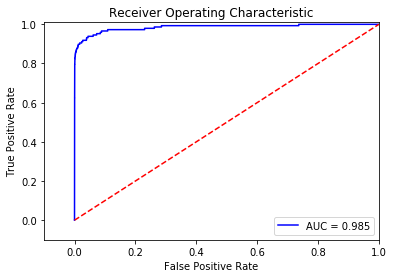

In [36]:
#ROC
y_pred_sample_score = tmp.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Conclusion:

|  Sampling   |       Model       |  SearchCV  |Scoring Metrics|Train_model_score|Test_model_score|best panalty|Best lambda|
|-------------|-------------------|------------|---------------|----------------:|---------------:|------------|----------:|
|SMOTE        |Logistic Regression|GridSearchCV|accuracy       |          0.97525|          0.9452|l1          |          4|
|SMOTE        |Logistic Regression|GridSearchCV|precision      |          0.06032|          0.9731|l1          |          1|
|SMOTE        |Logistic Regression|GridSearchCV|recall         |          0.91837|          0.9157|l1          |          4|
|SMOTE        |Logistic Regression|GridSearchCV|f1             |          0.11321|          0.9435|l1          |          4|
|UnderSampling|Logistic Regression|GridSearchCV|accuracy       |          0.94898|          0.9518|l1          |          5|
|UnderSampling|Logistic Regression|GridSearchCV|precision      |          0.94898|          0.9759|l1          |          5|
|UnderSampling|Logistic Regression|GridSearchCV|recall         |          0.94898|          0.9264|l1          |          5|
|UnderSampling|Logistic Regression|GridSearchCV|f1             |          0.94898|          0.9505|l1          |          5|

## FutureWork:
1. Implementing Random Forest and other classifiers.
2. Increasing Accuracy